# Russian - Solution Lesson 9 on Fast.ai
> Abbreviated solution of the lesson 9 on fast.ai

- toc: true
- branch: master
- badges: true
- comments: true
- author: Zmey56
- categories: [russian, fast.ai, solution]

In [1]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [2]:
#hide
!pip install dtreeviz

In [3]:
#hide
from fastbook import *
from kaggle import *
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

In [4]:
!pip install fastai --upgrade

Requirement already up-to-date: fastai in /opt/conda/envs/fastai/lib/python3.8/site-packages (2.2.5)


Сначало пришлось выполнить настройки. Во первых получить файл kaggle.json, который необходимо скачать из свой учетной записи на kaggle. Он находится в подразделе Account. Немного прокрутить вниз до подраздела API и нажать на кнопку Create new API token. После этого его закачал при помощи своего Jupyter notebook, так же в Jupyter запустил терминал находясь в той же папке где и файл и выполнил команду: *mv kaggle.json ~/.kaggle/kaggle.json*

# Глубокое погружение в табличное моделирование

## Категориальные вложения

Непрерывные и категориальные переменные: Непрерывные переменные-это числовые данные (например "возраст"), которые могут складываться и умножаться. Категориальные переменные - это дискретные значения (например "идентификатор фильма"), для которых сложение и умножение не имеют никакого смысла значения (даже если они представлены в виде чисел).

## За пределами Глубокого обучения

Последние исследования показали, что подавляющее большинство наборов данных лучше всего моделируется всего двумя методами:

* Ансамблями деревьев решений (например, случайные леса и механизмы градиентного бустинга), которые в основном используются для структурированных данных (таких, которые вы можете найти в таблице базы данных большинства компаний)
* Многослойными нейронными сетями, обучаемыми с помощью SGD (т. е. неглубокого и/или глубокого обучения), в основном для неструктурированных данных (таких как аудио, изображения и естественного языка)

## The Dataset

Набор данных, который мы используем в этой главе, взят из соревнования на Kaggle "Blue Book for Bulldozers", которое имеет следующее описание: "Цель конкурса-предсказать цену продажи конкретной единицы тяжелой техники на аукционе на основе ее применения, типа оборудования и конфигурации. Эти данные получены из размещенных результатов аукциона и включают информацию об использовании и конфигурации оборудования."

### Kaggle Competitions

Необходимо открыть загруженный файл *kaggle.json* и скопировать его содержимое в следующую ячейку

In [5]:
creds = '{"username":"zmey56","key":"dc7d155a89b02fbe2ef2078f6e098e71"}'

In [6]:
cred_path = Path('~/.kaggle/kaggle.json').expanduser()
if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write(creds)
    cred_path.chmod(0o600)

Теперь вы можете скачать наборы данных из Kaggle! Выберите путь для загрузки набора:

In [7]:
path = URLs.path('bluebook')
path

Path('/storage/archive/bluebook')

In [8]:
#hide
Path.BASE_PATH = path

И используйте Kaggle API, чтобы загрузить набор данных по этому пути и извлечь его:

In [9]:
if not path.exists():
    path.mkdir()
    api.competition_download_cli('bluebook-for-bulldozers', path=path)
    file_extract(path/'bluebook-for-bulldozers.zip')

path.ls(file_type='text')

(#7) [Path('median_benchmark.csv'),Path('ValidSolution.csv'),Path('Machine_Appendix.csv'),Path('random_forest_benchmark_test.csv'),Path('TrainAndValid.csv'),Path('Test.csv'),Path('Valid.csv')]

Теперь, когда мы загрузили наш набор данных, давайте взглянем на него!

### Посмотрите на данные

Kaggle предоставляет информацию о некоторых полях набора данных. Ключевыми значениями в train.csv являются:

* SalesID:: Уникальный идентификатор продажи.
* MachineID:: Уникальный идентификатор машины. Машина может быть продана несколько раз.
* saleprice:: За что машина продается на аукционе (предоставляется только в train.csv).
* saledate:: Дата продажи.

Давайте загрузим наши данные и посмотрим на столбцы

In [10]:
df = pd.read_csv(path/'TrainAndValid.csv', low_memory=False)

In [11]:
df.columns

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'saledate', 'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc',
       'fiModelSeries', 'fiModelDescriptor', 'ProductSize',
       'fiProductClassDesc', 'state', 'ProductGroup', 'ProductGroupDesc',
       'Drive_System', 'Enclosure', 'Forks', 'Pad_Type', 'Ride_Control',
       'Stick', 'Transmission', 'Turbocharged', 'Blade_Extension',
       'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower', 'Hydraulics',
       'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control', 'Tire_Size',
       'Coupler', 'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow',
       'Track_Type', 'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb',
       'Pattern_Changer', 'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type',
       'Travel_Controls', 'Differential_Type', 'Steering_Controls'],
      dtype='object')

Cледующим шагом обрабатываются порядковые столбцы. Например - уровни ProductSize:

In [12]:
df['ProductSize'].unique()

array([nan, 'Medium', 'Small', 'Large / Medium', 'Mini', 'Large', 'Compact'], dtype=object)

Мы можем рассказать Pandas о подходящем порядке этих уровней примерно так

In [13]:
sizes = 'Large','Large / Medium','Medium','Small','Mini','Compact'

In [14]:
df['ProductSize'] = df['ProductSize'].astype('category')
df['ProductSize'].cat.set_categories(sizes, ordered=True, inplace=True)

В этом случае Kaggle говорит нам, какую метрику использовать: лог среднеквадратичной ошибки (RMSLE) между фактической и прогнозируемой аукционными ценами. Нам нужно сделать только небольшое количество обработки, чтобы использовать это: мы берем лог цен, так что rmse его даст нам то, что нам в конечном счете нужно:

In [15]:
dep_var = 'SalePrice'

In [16]:
df[dep_var] = np.log(df[dep_var])

## Деревья решения

### Обработка данных

Заменим каждый столбец данных набором столбцов метаданных даты, таких как праздник, день недели и месяц. Эти столбцы содержат категориальные данные, которые, как мы подозреваем, будут полезны. fastai поставляется с функцией, которая сделает это за нас—нам просто нужно передать имя столбца, содержащего данные:

In [17]:
df = add_datepart(df, 'saledate')

Давайте то же самое сделаем для тестового набора

In [18]:
df_test = pd.read_csv(path/'Test.csv', low_memory=False)
df_test = add_datepart(df_test, 'saledate')

Мы видим, что теперь в нашем фрейме данных появилось много новых столбцов

In [19]:
' '.join(o for o in df.columns if o.startswith('sale'))

'saleWeek saleYear saleMonth saleDay saleDayofweek saleDayofyear saleIs_month_end saleIs_month_start saleIs_quarter_end saleIs_quarter_start saleIs_year_end saleIs_year_start saleElapsed'

### Использование TabularPandas и TabularProc

Categorify-это TabularProc, который заменяет столбец числовым категориальным столбцом. FillMissing-это TabularProc, который заменяет отсутствующие значения медианой столбца и создает новый логический столбец, который имеет значение True для любой строки, где значение отсутствовало. Эти два преобразования необходимы почти для каждого табличного набора данных, который вы будете использовать, так что это хорошая стартовая точка для обработки ваших данных:

In [20]:
procs = [Categorify, FillMissing]

Так как это временной ряд, то разделение на обучающие и проверочные случайным образом не получиться.В некоторых случаях это можно сделать просто случайным образом, выбрав подмножество точек данных. В связи с этим мы используем np.where, полезную функцию, которая возвращает (в качестве первого элемента кортежа) индексы всех истинных значений:

In [21]:
cond = (df.saleYear<2011) | (df.saleMonth<10)
train_idx = np.where( cond)[0]
valid_idx = np.where(~cond)[0]

splits = (list(train_idx),list(valid_idx))

TabularPandas нужно сказать, какие столбцы являются непрерывными, а какие категориальными. Мы можем справиться с этим автоматически с помощью вспомогательной функции cont_cat_split. Но это меня привело к ошибке:
```
TypeError: Cannot interpret 'UInt32Dtype()' as a data type
```
Поиск по форумам не дал много ответов, но одно из решений удалось найти:

In [22]:
df = df.astype({'saleWeek' : 'uint32'})

In [23]:
def cont_cat_split(df, max_card=20, dep_var=None):
    cont_names, cat_names = [], []
    for label in df:
        if label in L(dep_var): continue
        
        # mod to detect ProductSize type properly
        if (df[label].dtype.name == 'category'):
          cat_names.append(label)
          continue

        if (np.issubdtype(df[label].dtype, np.integer) and
            df[label].unique().shape[0] > max_card or
            np.issubdtype(df[label].dtype, np.floating)):
            cont_names.append(label)
        else: cat_names.append(label)
    return cont_names, cat_names

In [24]:
cont,cat = cont_cat_split(df, 1, dep_var=dep_var)

In [25]:
to = TabularPandas(df, procs, cat, cont, y_names=dep_var, splits=splits)

TabularPandas ведет себя очень похоже на fastai Datasets объект, в том числе предоставление train и valid признаков

In [26]:
len(to.train),len(to.valid)

(404710, 7988)

Мы видим, что данные по-прежнему отображаются в виде строк для категорий (здесь мы показываем только несколько строк, потому что полная таблица слишком велика, чтобы поместиться на странице):

In [27]:
to.show(3)

,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed,auctioneerID_na,MachineHoursCurrentMeter_na,SalesID,MachineID,saleWeek,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,saleYear,saleMonth,saleDay,saleDayofweek,saleDayofyear,SalePrice
0,Low,521D,521,D,#na#,#na#,#na#,Wheel Loader - 110.0 to 120.0 Horsepower,Alabama,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,1163635200,False,False,1139246,999089,46,3157,121,3.0,2004,68.0,2006,11,16,3,320,11.097410
1,Low,950FII,950,F,II,#na#,Medium,Wheel Loader - 150.0 to 175.0 Horsepower,North Carolina,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,23.5,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,1080259200,False,False,1139248,117657,13,77,121,3.0,1996,4640.0,2004,3,26,4,86,10.950807
2,High,226,226,#na#,#na#,#na#,#na#,Skid Steer Loader - 1351.0 to 1601.0 Lb Operating Capacity,New York,SSL,Skid Steer Loaders,#na#,OROPS,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Auxiliary,#na#,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,None or Unspecified,Standard,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,False,False,False,False,False,False,1077753600,False,False,1139249,434808,9,7009,121,3.0,2001,2838.0,2004,2,26,3,57,9.210340


In [28]:
to1 = TabularPandas(df, procs, ['state', 'ProductGroup', 'Drive_System', 'Enclosure'], [], y_names=dep_var, splits=splits)
to1.show(3)

,state,ProductGroup,Drive_System,Enclosure,SalePrice
0,Alabama,WL,#na#,EROPS w AC,11.097410
1,North Carolina,WL,#na#,EROPS w AC,10.950807
2,New York,SSL,#na#,OROPS,9.210340


Однако все базовые элементы являются числовыми:

In [29]:
to.items.head(3)

,SalesID,SalePrice,MachineID,saleWeek,...,saleIs_year_start,saleElapsed,auctioneerID_na,MachineHoursCurrentMeter_na
0,1139246,11.097410,999089,46,...,1,2647,1,1
1,1139248,10.950807,117657,13,...,1,2148,1,1
2,1139249,9.210340,434808,9,...,1,2131,1,1


In [30]:
to1.items[['state', 'ProductGroup', 'Drive_System', 'Enclosure']].head(3)

,state,ProductGroup,Drive_System,Enclosure
0,1,6,0,3
1,33,6,0,3
2,32,3,0,6


Преобразование категориальных столбцов в числа осуществляется путем простой замены каждого числом уникального значения. Мы можем увидеть их, посмотрев на атрибут *classes*:

In [31]:
to.classes['ProductSize']

['#na#', 'Large', 'Large / Medium', 'Medium', 'Small', 'Mini', 'Compact']

Поскольку обработка данных занимает около минуты, чтобы добраться до этой точки, мы должны сохранить ее—таким образом, в будущем мы сможем продолжить нашу работу отсюда, не повторяя предыдущие шаги. fastai предоставляет метод сохранения, который использует систему pickle Python для сохранения практически любого объекта Python:

In [32]:
#(path/'to.pkl').save(to)
save_pickle(path/'to.pkl',to)

### Создание деревьев решений

Для начала определим наши независимые и зависимые переменные:

In [33]:
#hide
#to = (path/'to.pkl').load()
to = load_pickle(path/'to.pkl')

In [34]:
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y

Теперь, когда все наши данные числовые и нет пропущенных значений, мы можем создать дерево решений:

In [35]:
m = DecisionTreeRegressor(max_leaf_nodes=4)
m.fit(xs, y);

Чтобы все было просто, мы сказали sklearn просто создать четыре листовых узла. Чтобы увидеть, чему он научился, мы можем показать дерево

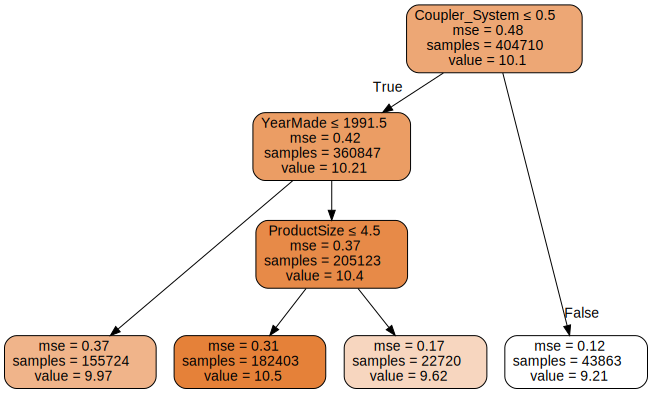

In [36]:
draw_tree(m, xs, leaves_parallel=True, precision=2)

Мы можем показать разложение с помощью мощной библиотеки dtreeviz Теренса Парра:

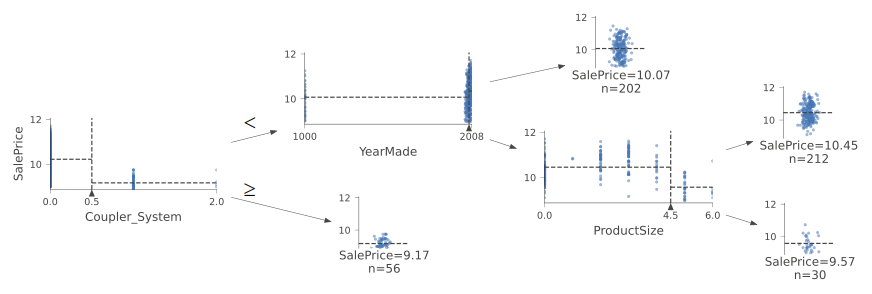

In [37]:
samp_idx = np.random.permutation(len(y))[:500]
dtreeviz(m, xs.iloc[samp_idx], y.iloc[samp_idx], xs.columns, dep_var,
        fontname='DejaVu Sans', scale=1.6, label_fontsize=10,
        orientation='LR')

С целью удобства визуализации давайте заменим отсутствующие значения, которые у нас обозначены через 1000 на 1950 год:

In [38]:
xs.loc[xs['YearMade']<1900, 'YearMade'] = 1950
valid_xs.loc[valid_xs['YearMade']<1900, 'YearMade'] = 1950

Проверим насколько устойчивы деревья решений к проблемам с данными!

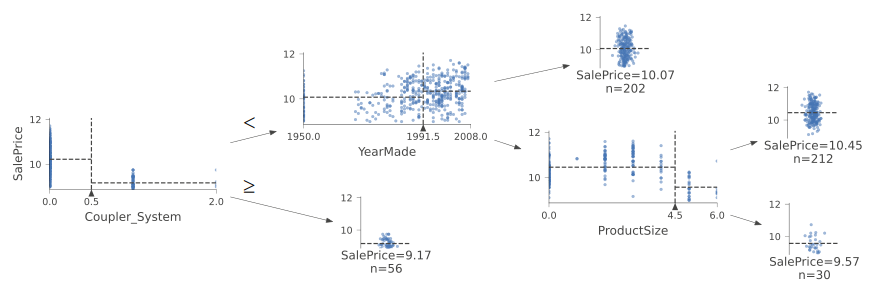

In [39]:
m = DecisionTreeRegressor(max_leaf_nodes=4).fit(xs, y)

dtreeviz(m, xs.iloc[samp_idx], y.iloc[samp_idx], xs.columns, dep_var,
        fontname='DejaVu Sans', scale=1.6, label_fontsize=10,
        orientation='LR')

Теперь пусть алгоритм дерева решений построит дерево побольше. Здесь мы не передаем никаких критериев остановки, таких как *max_leaf_nodes*:

In [40]:
m = DecisionTreeRegressor()
m.fit(xs, y);

Мы создадим небольшую функцию для проверки среднеквадратичной ошибки нашей модели (m_rmse), поскольку именно так оценивался конкурс:

In [41]:
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

In [42]:
m_rmse(m, xs, y)

0.0

Проверим набор валидации, чтобы убедиться, что мы не переобучены:

In [43]:
m_rmse(m, valid_xs, valid_y)

0.331671

Упс—похоже, мы сильно переобучились. Вот почему:

In [44]:
m.get_n_leaves(), len(xs)

(324552, 404710)

Давайте изменим правило остановки и скажем sklearn, чтобы каждый конечный узел содержал по крайней мере 25 записей:

In [45]:
m = DecisionTreeRegressor(min_samples_leaf=25)
m.fit(to.train.xs, to.train.y)
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.248595, 0.323399)

Давайте еще раз проверим количество листьев:

In [46]:
m.get_n_leaves()

12397

## Random Forests

Чтобы увидеть, как это работает на практике, давайте начнем создавать свой собственный случайный лес!

In [47]:
#hide
# pip install —pre -f https://sklearn-nightly.scdn8.secure.raxcdn.com scikit-learn —U

### Создание случайного леса

В следующей функции n_estimators задает количество деревьев, которое нам необходимо, max_samples - сколько строк использовать из выборки для обучения каждого дерева, max_features - число признаков, по которым ищется разбиение. Вы можете указать конкретное число или процент признаков, либо выбрать из доступных значений: "auto" (все признаки), "sqrt", "log2". По дефолту стоит "auto". Мы также можем указать, когда следует прекратить разбиение дерева используя параметр min_samples_leaf. Наконец, мы передаем n_jobs=-1, чтобы сказать sklearn использовать все наши процессоры для параллельного построения деревьев:

In [48]:
def rf(xs, y, n_estimators=40, max_samples=200_000,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [49]:
m = rf(xs, y);

Наша валидация RMSE теперь значительно улучшена по сравнению с нашим последним результатом, полученным DecisionTreeRegressor, который построил только одно дерево для всех доступных данных:

In [50]:
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.170808, 0.232406)

Чтобы увидеть влияние n_estimators, давайте получим прогнозы от каждого отдельного дерева в нашем лесу (они находятся в атрибуте estimators):

In [51]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])

Как вы можете видеть, preds.mean(0) дает те же результаты, что и наш случайный лес:

In [52]:
r_mse(preds.mean(0), valid_y)

0.232406

Давайте посмотрим, что происходит с RMSE, когда мы добавляем все больше и больше деревьев. Как вы можете видеть, улучшение становиться более пологим после около 30 деревьев:

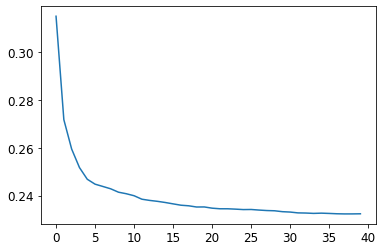

In [53]:
plt.plot([r_mse(preds[:i+1].mean(0), valid_y) for i in range(40)]);

### Out-of-Bag Error

Если простым языком, то поскольку каждое дерево было обучено с различным случайно выбранным подмножеством строк, ошибка out-of-bag немного похожа на представление о том, что каждое дерево, следовательно, также имеет свой собственный набор проверки. Этот набор проверки-это просто строки, которые не были выбраны для обучения этого дерева.

Прогнозы OOB доступны в атрибуте oob_prediction_. Обратите внимание, что мы сравниваем их с обучающими метками, так как это вычисляется на деревьях с использованием обучающего набора.

In [54]:
r_mse(m.oob_prediction_, y)

0.21052

## Интерпритация модели

### Достоверность прогноза на основании дисперсии

В предыдущем разделе, посвященном созданию случайного леса, мы видели, как получить прогнозы по набору проверки, используя списки Python для каждого дерева в лесу:

In [55]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])

In [56]:
preds.shape

(40, 7988)

Теперь у нас есть прогноз для каждого дерева и каждого аукциона (40 деревьев и 7 988 аукционов) в наборе проверки.

Используя это, мы можем получить стандартное отклонение прогнозов по всем деревьям для каждого аукциона:

In [57]:
preds_std = preds.std(0)

Посмотрим на стандартные отклонения для прогнозов для первых пяти аукционов—то есть первых пяти строк проверочного набора:

In [58]:
preds_std[:5]

array([0.20852237, 0.11403559, 0.09531696, 0.23696253, 0.11246767])

### Важность признаков

Важность можем получить их непосредственно из случайного леса sklearn, заглянув в атрибут feature_importances_. Вот простая функция, которую мы можем использовать, чтобы поместить их в DataFrame и отсортировать:

In [59]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

Важность признаков для нашей модели показывают, что первые несколько наиболее важных столбцов имеют гораздо более высокие оценки важности, чем остальные, причем (что неудивительно) YearMade и ProductSize находятся в верхней части списка:

In [60]:
fi = rf_feat_importance(m, xs)
fi[:10]

,cols,imp
59,YearMade,0.171312
30,Coupler_System,0.119788
6,ProductSize,0.114872
7,fiProductClassDesc,0.068519
56,ModelID,0.054451
3,fiSecondaryDesc,0.053365
50,saleElapsed,0.050239
12,Enclosure,0.038051
31,Grouser_Tracks,0.037815
32,Hydraulics_Flow,0.032734


График важности признаков показывает это более наглядно:

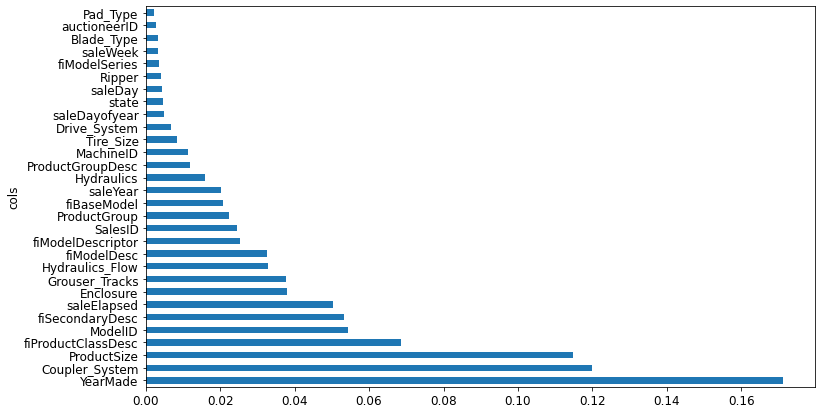

In [61]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:30]);

### Удаление Переменных с Низкой Важностью

Вполне вероятно, что мы могли бы провести достаточно неплохой расчет и без столбцов с низкой важностью. Давайте попробуем оставить только те, важность которых превышает 0,005:

In [62]:
to_keep = fi[fi.imp>0.005].cols
len(to_keep)

21

Теперь переообучим нашу модель:

In [63]:
xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]

In [64]:
m = rf(xs_imp, y)

И вот результат:

In [65]:
m_rmse(m, xs_imp, y), m_rmse(m, valid_xs_imp, valid_y)

(0.181104, 0.230574)

Наша точность примерно такая же, но у нас гораздо меньше признаков для изучения:

In [66]:
len(xs.columns), len(xs_imp.columns)

(66, 21)

Это также облегчает интерпретацию нашего графика важности признаков. Давайте посмотрим на это еще раз:

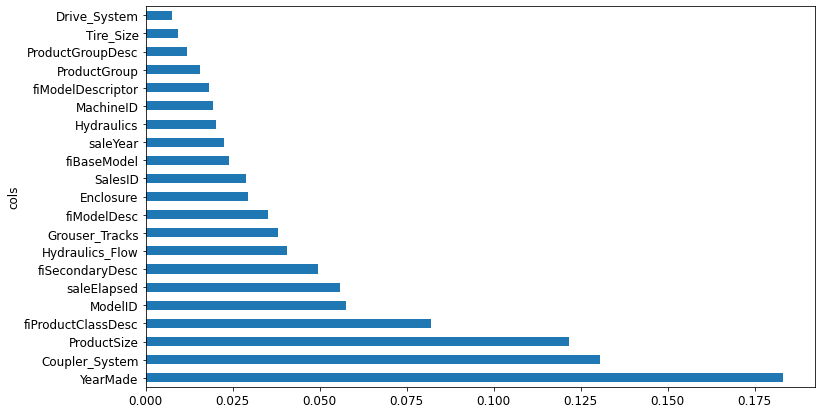

In [67]:
plot_fi(rf_feat_importance(m, xs_imp));

### Удаление дублирующих признаков

Определение сходства: Наиболее похожие пары определяются путем вычисления ранговой корреляции, что означает, что все значения заменяются их рангом, а затем вычисляется корреляция. 

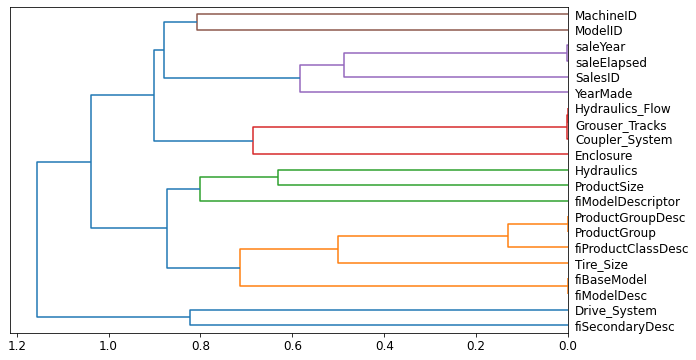

In [68]:
cluster_columns(xs_imp)

Давайте попробуем удалить некоторые из этих тесно связанных признаков, чтобы увидеть, можно ли упростить модель, не влияя на точность. Во-первых, мы создаем функцию, которая быстро обучает случайный лес и возвращает оценку OOB, используя более низкий max_samples и более высокий min_samples_leaf. Оценка OOB - это число, возвращаемое sklearn, которое колеблется между 1,0 для идеальной модели и 0,0 для случайной модели. (В статистике это называется R^2, хотя детали не важны для этого объяснения.) Нам не нужно, чтобы оно был очень точным—мы просто будем использовать его для сравнения различных моделей, основанных на удалении некоторых, возможно дублирующих столбцов:

In [69]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=15,
        max_samples=50000, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(df, y)
    return m.oob_score_

Вот наш Baseline

In [70]:
get_oob(xs_imp)

0.8764410377988594

Теперь мы попытаемся удалить каждую из наших потенциально дублирующих переменных, по одной за раз:

In [71]:
{c:get_oob(xs_imp.drop(c, axis=1)) for c in (
    'saleYear', 'saleElapsed', 'ProductGroupDesc','ProductGroup',
    'fiModelDesc', 'fiBaseModel',
    'Hydraulics_Flow','Grouser_Tracks', 'Coupler_System')}

{'saleYear': 0.8761576456556869,
 'saleElapsed': 0.8720694164876017,
 'ProductGroupDesc': 0.8773236585083313,
 'ProductGroup': 0.8767961703098911,
 'fiModelDesc': 0.8763622619440036,
 'fiBaseModel': 0.8756228700540764,
 'Hydraulics_Flow': 0.8778530782106663,
 'Grouser_Tracks': 0.8772923083390904,
 'Coupler_System': 0.8778145616354095}

Теперь давайте попробуем отбросить несколько переменных. Мы отбросим по одному от каждой из плотно взаимосвязанных в парах. Посмотрим, что это даст:

In [72]:
to_drop = ['saleYear', 'ProductGroupDesc', 'fiBaseModel', 'Grouser_Tracks']
get_oob(xs_imp.drop(to_drop, axis=1))

0.8751218470772454

Хорошо выглядит и не намного хуже, чем модель со всеми значениями. Давайте создадим DataFrame без этих столбцов и сохраним его:

In [73]:
xs_final = xs_imp.drop(to_drop, axis=1)
valid_xs_final = valid_xs_imp.drop(to_drop, axis=1)

Старый код не сработал, пришлось опять искать ответ

In [74]:
#(path/'xs_final.pkl').save(xs_final)
#(path/'valid_xs_final.pkl').save(valid_xs_final)

save_pickle(path/'xs_final.pkl', xs_final)
save_pickle(path/'valid_xs_final.pkl', valid_xs_final)

Мы можем его загрузить

In [75]:
xs_final = load_pickle(path/'xs_final.pkl')
valid_xs_final = load_pickle(path/'valid_xs_final.pkl')

Теперь мы можем снова проверить наш RMSE, чтобы убедиться, что точность существенно не изменилась.

In [76]:
m = rf(xs_final, y)
m_rmse(m, xs_final, y), m_rmse(m, valid_xs_final, valid_y)

(0.183382, 0.23278)

### Частичная Зависимость

Как мы уже видели, два наиболее важных предиктора-это ProductSize и YearMade. Мы хотели бы понять взаимосвязь между этими предикторами и ценой продажи. Рекомендуется сначала проверить количественно значение для каждой категории (при помощи метода Pandas value_counts):

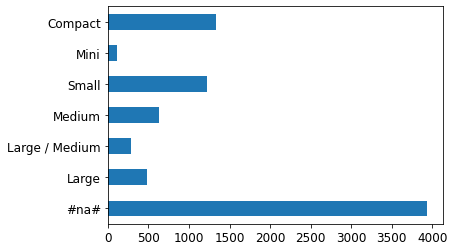

In [77]:
p = valid_xs_final['ProductSize'].value_counts(sort=False).plot.barh()
c = to.classes['ProductSize']
plt.yticks(range(len(c)), c);


Самая большая группа - #na#, это метка, которую fastai применяет к пропущенным значениям.

Давайте сделаем то же самое для YearMade. Поскольку это числовая значение, нам нужно нарисовать гистограмму, которая сгруппирует значения по годам:

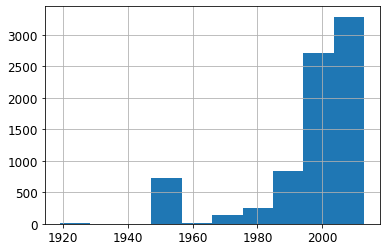

In [78]:
ax = valid_xs_final['YearMade'].hist()

Мы заменим каждое значение в столбце YearMade на значение из 1950, а затем рассчитаем прогнозируемую цену продажи для каждого аукциона и возьмем среднее значение по всем аукционам. Затем мы делаем то же самое для 1951, 1952 и так далее до нашего последнего 2011 года. Это изолирует эффект для YearMade.

С помощью этих средних значений мы можем построить график с годами по оси x и каждым из полученных прогнозов-по оси y. Давайте посмотрим:

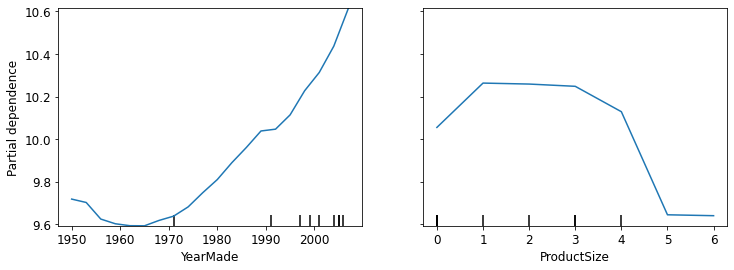

In [79]:
from sklearn.inspection import plot_partial_dependence

fig,ax = plt.subplots(figsize=(12, 4))
plot_partial_dependence(m, valid_xs_final, ['YearMade','ProductSize'],
                        grid_resolution=20, ax=ax);

### Утечка данных

Тривиальным примером утечки может служить модель, которая использует саму цель в качестве входных данных:"в дождливые дни идет дождь".

### Интерпретатор дерева

In [80]:
#hide
!pip install treeinterpreter
!pip install waterfallcharts

In [81]:
#hide
import warnings
warnings.simplefilter('ignore', FutureWarning)

from treeinterpreter import treeinterpreter
from waterfall_chart import plot as waterfall

Давайте выберем первые несколько строк нашего набора проверки:

In [82]:
row = valid_xs_final.iloc[:5]

Затем мы можем передать их treeinterpreter:

In [83]:
prediction,bias,contributions = treeinterpreter.predict(m, row.values)

prediction-это просто предсказание, которое делает случайный лес. bias-это предсказание, основанное на принятии среднего значения зависимой переменной (то есть модели, которая является корнем каждого дерева). contributions—это самый интересный бит-он говорит нам об общем изменении предсказания из-за каждой из независимых переменных. Следовательно, сумма contributions плюс bias должна равняться prediction для каждой строки. Давайте посмотрим только на первый ряд:

In [84]:
prediction[0], bias[0], contributions[0].sum()

(array([10.01255406]), 10.104746057831763, -0.092191998676771)

Самый ясный способ отображения вкладов-это график водопада (waterfall plot). Он показывает, как положительные и отрицательные вклады всех независимых переменных суммируются, чтобы создать окончательный прогноз, который является правым столбцом с надписью "net":

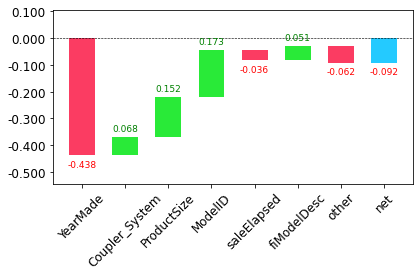

In [85]:
waterfall(valid_xs_final.columns, contributions[0], threshold=0.08, 
          rotation_value=45,formatting='{:,.3f}');

## Экстраполяция и нейронные сети

### Проблема экстрополяции

In [86]:
#hide
np.random.seed(42)

Давайте рассмотрим простую задачу построения прогнозов из 40 точек данных, показывающих слегка зашумленную линейную зависимость:

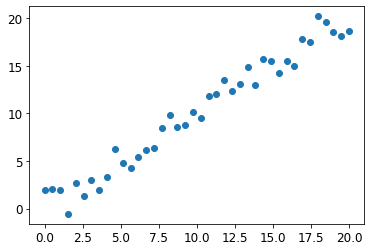

In [87]:
x_lin = torch.linspace(0,20, steps=40)
y_lin = x_lin + torch.randn_like(x_lin)
plt.scatter(x_lin, y_lin);

Хотя у нас есть только одна независимая переменная, sklearn ожидает матрицу независимых переменных, а не один вектор. Поэтому мы должны превратить наш вектор в матрицу с одним столбцом. Другими словами, мы должны изменить форму с \[40\] на \[40,1\]. Один из способов сделать это-с помощью метода unsqueeze, который добавляет новую единичную ось к тензору в требуемом измерении:

In [88]:
xs_lin = x_lin.unsqueeze(1)
x_lin.shape,xs_lin.shape

(torch.Size([40]), torch.Size([40, 1]))

Более гибкий подход состоит в том, чтобы сделать срез массива или тензора со специальным значением None, которое вводит тогда дополнительную единичную ось:

In [89]:
x_lin[:,None].shape

torch.Size([40, 1])

Теперь мы можем создать случайный лес для этих данных. Мы будем использовать только первые 30 строк для обучения модели:

In [90]:
m_lin = RandomForestRegressor().fit(xs_lin[:30],y_lin[:30])

Затем мы протестируем модель на полном наборе данных. Синие точки-это обучающие данные, а красные-предсказания:

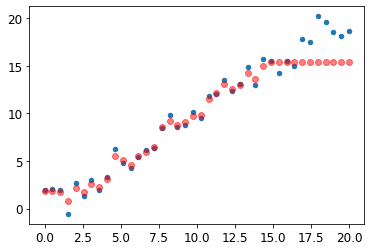

In [91]:
plt.scatter(x_lin, y_lin, 20)
plt.scatter(x_lin, m_lin.predict(xs_lin), color='red', alpha=0.5);

Случайные леса не могут экстраполироваться для данных, которые находятся за пределами тех, на которых они проходили обучение. 

### Поиск данных за пределами

Иногда трудно понять, распределен ли ваш тестовый набор таким же образом, как и ваши обучающие данные, или, если он отличается, какие столбцы отвечают за это. На самом деле есть простой способ понять это-использовать случайный лес!

Чтобы увидеть это в действии, давайте объединим наши обучающие и проверочные наборы вместе, создадим зависимую переменную, представляющую, из какого набора данных берется каждая строка, построим случайный лес, используя эти данные, и получим важность:

In [92]:
df_dom = pd.concat([xs_final, valid_xs_final])
is_valid = np.array([0]*len(xs_final) + [1]*len(valid_xs_final))

m = rf(df_dom, is_valid)
rf_feat_importance(m, df_dom)[:6]

,cols,imp
6,saleElapsed,0.904446
11,SalesID,0.070529
14,MachineID,0.020080
0,YearMade,0.001697
15,Tire_Size,0.000548
13,Hydraulics,0.000527


Давайте получим базовую линию RMSE исходной модели случайного леса, а затем посмотрим, каков эффект удаления каждого из этих столбцов по очереди:

In [93]:
m = rf(xs_final, y)
print('orig', m_rmse(m, valid_xs_final, valid_y))

for c in ('SalesID','saleElapsed','MachineID'):
    m = rf(xs_final.drop(c,axis=1), y)
    print(c, m_rmse(m, valid_xs_final.drop(c,axis=1), valid_y))

orig 0.232436
SalesID 0.23066
saleElapsed 0.235298
MachineID 0.231625


Похоже, мы можем удалить SalesID и MachineID без потери какой-либо точности. Давайте проверим:

In [94]:
time_vars = ['SalesID','MachineID']
xs_final_time = xs_final.drop(time_vars, axis=1)
valid_xs_time = valid_xs_final.drop(time_vars, axis=1)

m = rf(xs_final_time, y)
m_rmse(m, valid_xs_time, valid_y)

0.228595

Одна вещь, которая может помочь в нашем случае, - это просто избегать использования старых данных. Часто старые данные показывают отношения, которых больше нет. Давайте попробуем просто использовать данные за последние несколько лет:

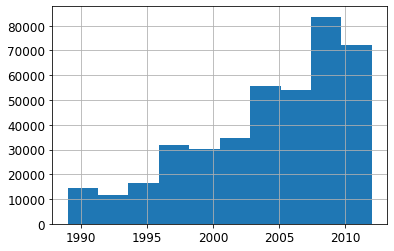

In [95]:
xs['saleYear'].hist();

Вот результат обучения на этом подмножестве:

In [96]:
filt = xs['saleYear']>2004
xs_filt = xs_final_time[filt]
y_filt = y[filt]

In [97]:
m = rf(xs_filt, y_filt)
m_rmse(m, xs_filt, y_filt), m_rmse(m, valid_xs_time, valid_y)

(0.177588, 0.229683)

### Использование нейроных сетей

Мы можем использовать тот же подход для построения нейросетевой модели. Давайте сначала повторим шаги, которые мы предприняли для настройки объекта TabularPandas:

In [98]:
df_nn = pd.read_csv(path/'TrainAndValid.csv', low_memory=False)
df_nn['ProductSize'] = df_nn['ProductSize'].astype('category')
df_nn['ProductSize'].cat.set_categories(sizes, ordered=True, inplace=True)
df_nn[dep_var] = np.log(df_nn[dep_var])
df_nn = add_datepart(df_nn, 'saledate')

Мы можем обрезать те же столбцы, что мы уже сделали в случайном лесу:

In [99]:
df_nn_final = df_nn[list(xs_final_time.columns) + [dep_var]]

In [100]:
cont_nn,cat_nn = cont_cat_split(df_nn_final, max_card=9000, dep_var=dep_var)

Есть одна переменная, которую мы абсолютно не хотим рассматривать как категориальную: переменная saleElapsed. Категориальная переменная по определению не может экстраполироваться за пределы диапазона значений, которые она видела, но мы хотим иметь возможность предсказывать аукционные цены продажи в будущем. Поэтому нам нужно сделать ее непрерывной переменной:

In [101]:
cont_nn.append('saleElapsed')
cat_nn.remove('saleElapsed')

Кроме того, чтобы использовать ее как непрерывную переменную, мы должны убедиться, что она имеет числовой тип:

In [102]:
df_nn['saleElapsed'] = df_nn['saleElapsed'].astype(int)

Давайте посмотрим на мощность каждой из категориальных переменных:

In [103]:
df_nn_final[cat_nn].nunique()

YearMade                73
Coupler_System           2
ProductSize              6
fiProductClassDesc      74
ModelID               5281
fiSecondaryDesc        177
Enclosure                6
Hydraulics_Flow          3
fiModelDesc           5059
fiModelDescriptor      140
ProductGroup             6
Hydraulics              12
Tire_Size               17
Drive_System             4
dtype: int64

Давайте посмотрим, какое влияние удаление одного из этих столбцов модели оказывает на случайный лес:

In [104]:
xs_filt2 = xs_filt.drop('fiModelDescriptor', axis=1)
valid_xs_time2 = valid_xs_time.drop('fiModelDescriptor', axis=1)
m2 = rf(xs_filt2, y_filt)
m_rmse(m2, xs_filt2, y_filt), m_rmse(m2, valid_xs_time2, valid_y)

(0.176528, 0.229976)

Mинимальное влияние, поэтому мы удалим его:

In [105]:
cat_nn.remove('fiModelDescriptor')

Для нейроной сети мы добавляем процесс нормализации:

In [106]:
df_nn_final = df_nn_final.astype({"saleElapsed": float})

In [107]:
df_nn_final.dtypes

YearMade                 int64
Coupler_System          object
ProductSize           category
fiProductClassDesc      object
ModelID                  int64
fiSecondaryDesc         object
saleElapsed            float64
Enclosure               object
Hydraulics_Flow         object
fiModelDesc             object
fiModelDescriptor       object
ProductGroup            object
Hydraulics              object
Tire_Size               object
Drive_System            object
SalePrice              float64
dtype: object

In [108]:
procs_nn = [Categorify, FillMissing, Normalize]
to_nn = TabularPandas(df_nn_final, procs_nn, cat_nn, cont_nn,
                      splits=splits, y_names=dep_var)

Табличные модели и данные обычно не требуют большого объема оперативной памяти GPU, поэтому мы можем использовать большие размеры пакетов

In [109]:
dls = to_nn.dataloaders(1024)

Давайте найдем min и max нашей зависимой переменной:

In [110]:
y = to_nn.train.y
y.min(),y.max()

(8.465899, 11.863583)

По умолчанию для табличных данных fastai создает нейронную сеть с двумя скрытыми слоями, с 200 и 100 активациями соответственно. Это довольно хорошо работает для небольших наборов данных, но здесь у нас есть довольно большой набор данных, поэтому мы увеличиваем размеры слоев до 500 и 250:

In [111]:
from fastai.tabular.all import *

In [112]:
learn = tabular_learner(dls, y_range=(8,12), layers=[500,250],
                        n_out=1, loss_func=F.mse_loss)

SuggestedLRs(lr_min=0.002754228748381138, lr_steep=0.0002754228771664202)

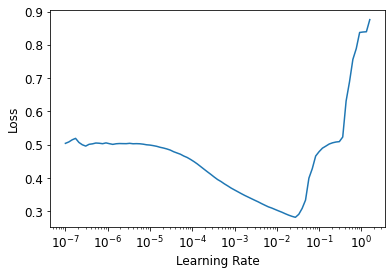

In [113]:
learn.lr_find()

Мы будем тренироваться с fit_one_cycle в течение нескольких эпох и посмотрим, как это выглядит:

In [114]:
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,time
0,0.069288,0.061883,00:07
1,0.055936,0.058179,00:07
2,0.049000,0.057057,00:07
3,0.043699,0.051876,00:07
4,0.040626,0.050812,00:07


Мы можем использовать нашу функцию r_mse для сравнения результата с результатом случайного леса, полученным ранее:

In [115]:
preds,targs = learn.get_preds()
r_mse(preds,targs)

0.225416

Это немного лучше, чем случайный лес (хотя обучение заняло больше времени, и оно более требовательно к настройке гиперпараметров).

Прежде чем мы двинемся дальше, давайте сохраним нашу модель на случай, если мы захотим вернуться к ней позже:

In [116]:
learn.save('nn')

Path('models/nn.pth')

## Ансамбль

Как мы видели ранее, случайный лес сам по себе является ансамблем. Мы можем включить случайный лес в другой ансамбль—ансамбль случайного леса и нейронной сети!

Одна незначительная проблема заключается в том, что наша модель PyTorch и наша модель sklearn создают данные разных типов: PyTorch дает нам тензор ранга-2 (то есть матрицу столбцов), тогда как NumPy дает нам массив ранга-1 (вектор). squeeze удаляет любые единичные оси из тензора, а to_np преобразует его в массив NumPy:

In [117]:
rf_preds = m.predict(valid_xs_time)
ens_preds = (to_np(preds.squeeze()) + rf_preds) /2

Это дает нам лучший результат, чем любая модель, построенная сама по себе:

In [118]:
r_mse(ens_preds,valid_y)

0.222111